In [74]:
import sys
from IPython.utils import io # I made a change - Is this visible in Github?

In [ ]:
# if 'google.colab' in sys.modules:

#   with io.capture_output() as captured:
#      ! pip install pyhgf watermark

In [75]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pymc as pm
import numpy as np

from pyhgf import load_data
from pyhgf.distribution import HGFDistribution
from pyhgf.model import HGF, Network
from pyhgf.response import first_level_gaussian_surprise
from pyhgf.utils import beliefs_propagation

plt.rcParams["figure.constrained_layout.use"] = True

In [3]:
# Disable JIT compilation globally
jax.config.update("jax_disable_jit", False) # True - If I want the compiler disabled.

NameError: name 'jax' is not defined

In [76]:
latent_hgf = (
    Network()
    .add_nodes(precision=1e4)
    .add_nodes(precision=1e4, mean=timeserie[0], tonic_volatility=-13.0, value_children=0)
    .add_nodes(precision=1e1, tonic_volatility=-2.0, volatility_children=0)
    .add_nodes(precision=1e4, mean=timeserie[0], tonic_volatility=-13.0, value_children=1)
    # .add_nodes(precision=1e1, tonic_volatility=-2.0, volatility_children=1)
    # .add_nodes(precision=1e4, mean=timeserie[0], tonic_volatility=-13.0, value_children=2)
    # .add_nodes(precision=1e1, tonic_volatility=-2.0, volatility_children=2)
).create_belief_propagation_fn()

# attributes, edges, update_sequence = (
#     latent_hgf.get_network()
# )

attributes, edges, update_sequence = (
    latent_hgf.get_network()
)

print(len(attributes))
print(len(edges))
print(attributes)

5
4
{-1: {'time_step': 0.0}, 0: {'mean': 0.0, 'expected_mean': 0.0, 'precision': 10000.0, 'expected_precision': 1.0, 'volatility_coupling_children': None, 'volatility_coupling_parents': (1.0,), 'value_coupling_children': None, 'value_coupling_parents': (1.0,), 'tonic_volatility': 0.0, 'tonic_drift': 0.0, 'autoconnection_strength': 0.0, 'observed': 1, 'temp': {'effective_precision': 0.0, 'value_prediction_error': 0.0, 'volatility_prediction_error': 0.0}}, 1: {'mean': 1.0357, 'expected_mean': 0.0, 'precision': 10000.0, 'expected_precision': 1.0, 'volatility_coupling_children': None, 'volatility_coupling_parents': None, 'value_coupling_children': (1.0,), 'value_coupling_parents': (1.0,), 'tonic_volatility': -13.0, 'tonic_drift': 0.0, 'autoconnection_strength': 1.0, 'observed': 1, 'temp': {'effective_precision': 0.0, 'value_prediction_error': 0.0, 'volatility_prediction_error': 0.0}}, 2: {'mean': 0.0, 'expected_mean': 0.0, 'precision': 10.0, 'expected_precision': 1.0, 'volatility_coupling_

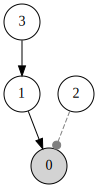

In [77]:
latent_hgf.plot_network()

In [ ]:

from typing import Dict
from pyhgf.typing import AdjacencyLists, Edges
from pyhgf.utils import add_edges

def latent_update(
        attributes: Dict,
        edges: Edges,
        index: int
    ):
    # Add new node to attributes

    print('attributes before changing anything:')
    print(attributes)

    print('node to be connected to:')
    print(index)

    new_node_idx = len(edges)  # Use len() to get the next index
    print('new_node_idx:')

    print(new_node_idx)
    attributes[new_node_idx] = {
        "mean": 0.0,
        "expected_mean": 0.0,
        "precision": 1.0,
        "expected_precision": 1.0,
        "volatility_coupling_children": None,
        "volatility_coupling_parents": None,
        "value_coupling_children": None,
        "value_coupling_parents": None,
        "tonic_volatility": -4.0,
        "tonic_drift": 0.0,
        "autoconnection_strength": 1.0,
        "observed": 1,
        "temp": {
            "effective_precision": 0.0,
            "value_prediction_error": 0.0,
            "volatility_prediction_error": 0.0,
        },
    }
    
    # Add new AdjacencyList(empty values) to Edges tuple
    new_adj_list = AdjacencyLists(2, None, None, None, None, None)
    edges = edges + (new_adj_list,)

    print('attributes after adding new empty node:')
    print(attributes)
    
    # Use add_edges to integrate the newly altered attributes and edges
    attributes, edges = add_edges(attributes, edges, 'value', new_node_idx, index) # If i understand correctly, the new node is incorrectly coupled to node nr. 1, instread of the intended node nr. 2
    
    print('attributes after adding value coupling:')
    print(attributes)

    # Return altered attributes and edges
    return attributes, edges

In [73]:
attributes, edges, update_sequence = (
    latent_hgf.get_network()
)

latent_hgf_alt_attributes, latent_hgf_alt_edges = latent_update(attributes, edges, 2)

attributes before changing anything:
{-1: {'time_step': 0.0}, 0: {'mean': 0.0, 'expected_mean': 0.0, 'precision': 10000.0, 'expected_precision': 1.0, 'volatility_coupling_children': None, 'volatility_coupling_parents': (1.0,), 'value_coupling_children': None, 'value_coupling_parents': (1.0,), 'tonic_volatility': 0.0, 'tonic_drift': 0.0, 'autoconnection_strength': 0.0, 'observed': 1, 'temp': {'effective_precision': 0.0, 'value_prediction_error': 0.0, 'volatility_prediction_error': 0.0}}, 1: {'mean': 1.0357, 'expected_mean': 0.0, 'precision': 10000.0, 'expected_precision': 1.0, 'volatility_coupling_children': None, 'volatility_coupling_parents': None, 'value_coupling_children': (1.0,), 'value_coupling_parents': (1.0,), 'tonic_volatility': -13.0, 'tonic_drift': 0.0, 'autoconnection_strength': 1.0, 'observed': 1, 'temp': {'effective_precision': 0.0, 'value_prediction_error': 0.0, 'volatility_prediction_error': 0.0}}, 2: {'mean': 0.0, 'expected_mean': 0.0, 'precision': 10.0, 'expected_preci

In [57]:
print(len(latent_hgf_alt_attributes))
print(len(latent_hgf_alt_edges))

6
5


In [71]:
latent_hgf[attributes] = latent_hgf_alt_attributes
latent_hgf[edges] = latent_hgf_alt_edges

TypeError: 'Network' object does not support item assignment